# nickyspatial Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/simple_usecase.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kshitijrajsharma/nickyspatial/master?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fexamples%2Fsimple_usecase.ipynb)

In this notebook we demonstrate how to use the `nickyspatial` library to read a raster, perform segmentation, calculate spectral indices (like NDVI), and apply rule-based classification. We then display the resulting figures inline. This example explains how rules are applied to classify segments.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [ ]:
! pip install nickyspatial

In [1]:
import os
import requests
import matplotlib.pyplot as plt

from nickyspatial import (
    LayerManager,
    MultiResolutionSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_layer,
    read_raster,
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "sample.tif")

if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/sample.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [2]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (4, 877, 1164)
Coordinate system: EPSG:32654


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [3]:
manager = LayerManager()

segmenter = MultiResolutionSegmentation(scale=40, compactness=1)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 638
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 638)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

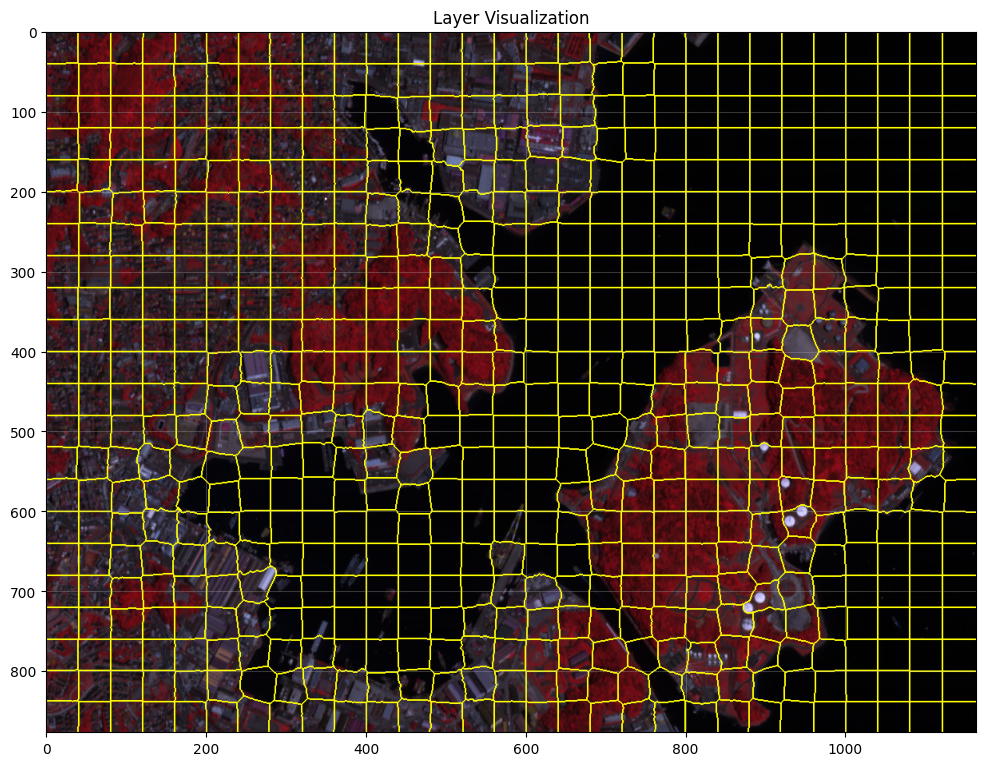

In [4]:
fig1 = plot_layer(segmentation_layer, image_data, rgb_bands=(3, 2, 1), show_boundaries=True)
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

## Calculating Spectral Indices (NDVI)

Next, we attach functions to the segmentation layer to calculate NDVI and other spectral indices. NDVI is a common metric to assess vegetation health. Here we are doing an example how to use the existing pre-defined rules in the library 

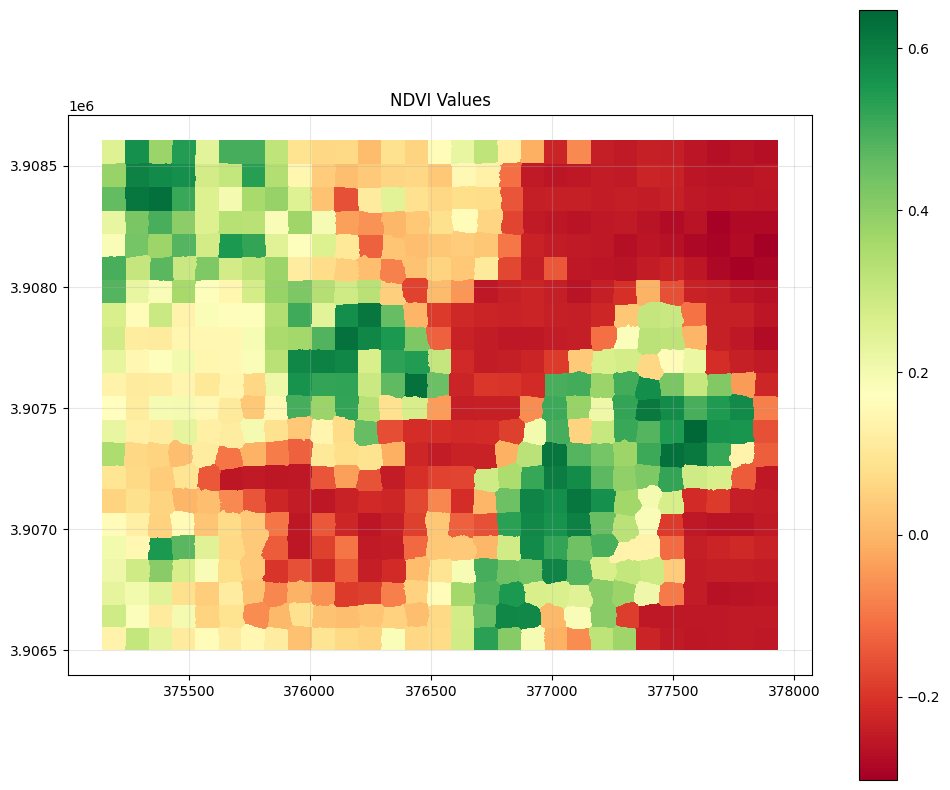

In [5]:
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)

segmentation_layer.attach_function(
    attach_spectral_indices,
    name="spectral_indices",
    bands={
        "blue": "band_1_mean",
        "green": "band_2_mean",
        "red": "band_3_mean",
        "nir": "band_4_mean",
    },
)

fig2 = plot_layer(segmentation_layer, attribute="NDVI", title="NDVI Values", cmap="RdYlGn")
plt.show()

fig2.savefig(os.path.join(output_dir, "2_ndvi.png"))

## Calculating Shape Metrics

In this step, we attach a function to calculate shape index of objects and export the segmentation results as a GeoJSON file.

In [6]:
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")

seg_geojson_path = os.path.join(output_dir, "segmentation.geojson")
layer_to_vector(segmentation_layer, seg_geojson_path)
print(f"Segmentation GeoJSON saved to {seg_geojson_path}")

Segmentation GeoJSON saved to output/segmentation.geojson


## Applying Land Cover Classification Rules

Now we demonstrate how to use rule-based classification. Rules are defined for the land cover classification. For example, we can define a rule that marks segments as `Vegetation` if their NDVI is greater than 0.2; all other segments are marked as `Other`.
With this technique we define our custom rule which can be in hierarchical order 
We then generate a classified layer and visualize the results.

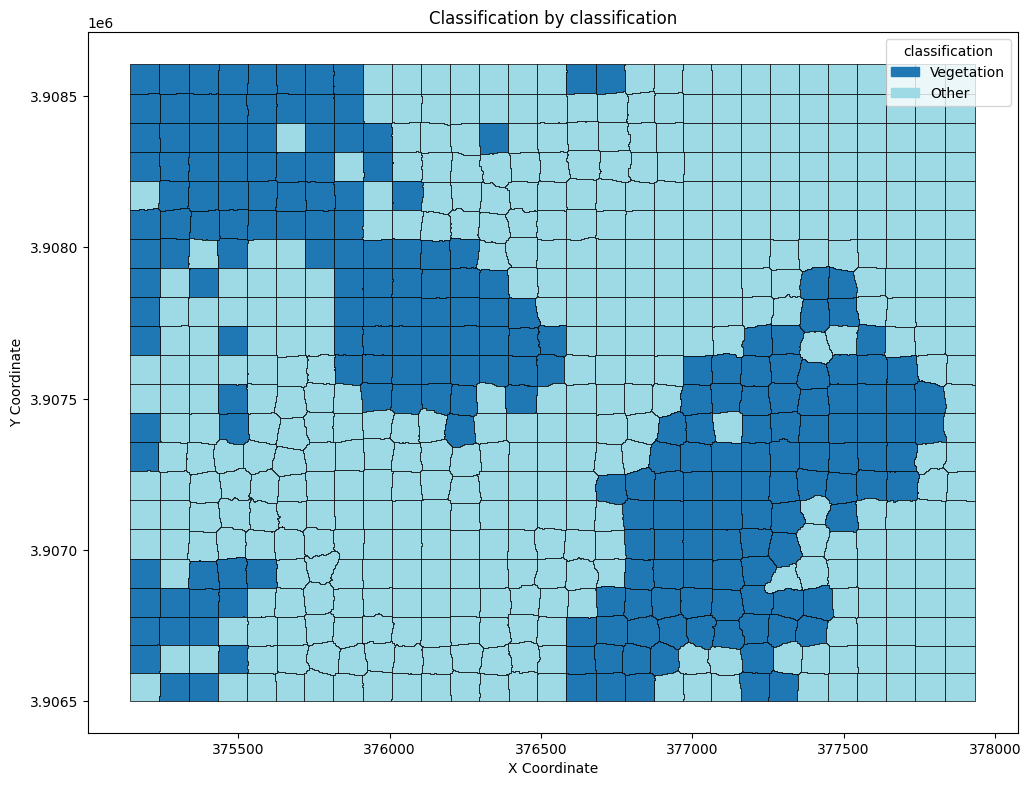

In [7]:
land_cover_rules = RuleSet(name="Land_Cover")
land_cover_rules.add_rule(name="Vegetation", condition="NDVI > 0.2")
land_cover_rules.add_rule(name="Other", condition="NDVI <= 0.2")

land_cover_layer = land_cover_rules.execute(
    segmentation_layer,
    layer_manager=manager,
    layer_name="Land_Cover",
)

fig3 = plot_classification(land_cover_layer, class_field="classification")
plt.show()

fig3.savefig(os.path.join(output_dir, "3_land_cover.png"))

## Applying Hierarchical Classification Rules

For further refinement, we can apply hierarchical rules. In this example, we subdivide the `Vegetation` class into categories such as `Healthy_Vegetation`, `Moderate_Vegetation`, and `Sparse_Vegetation` based on NDVI thresholds.

This demonstrates how you can build upon basic classifications to obtain more granular information.

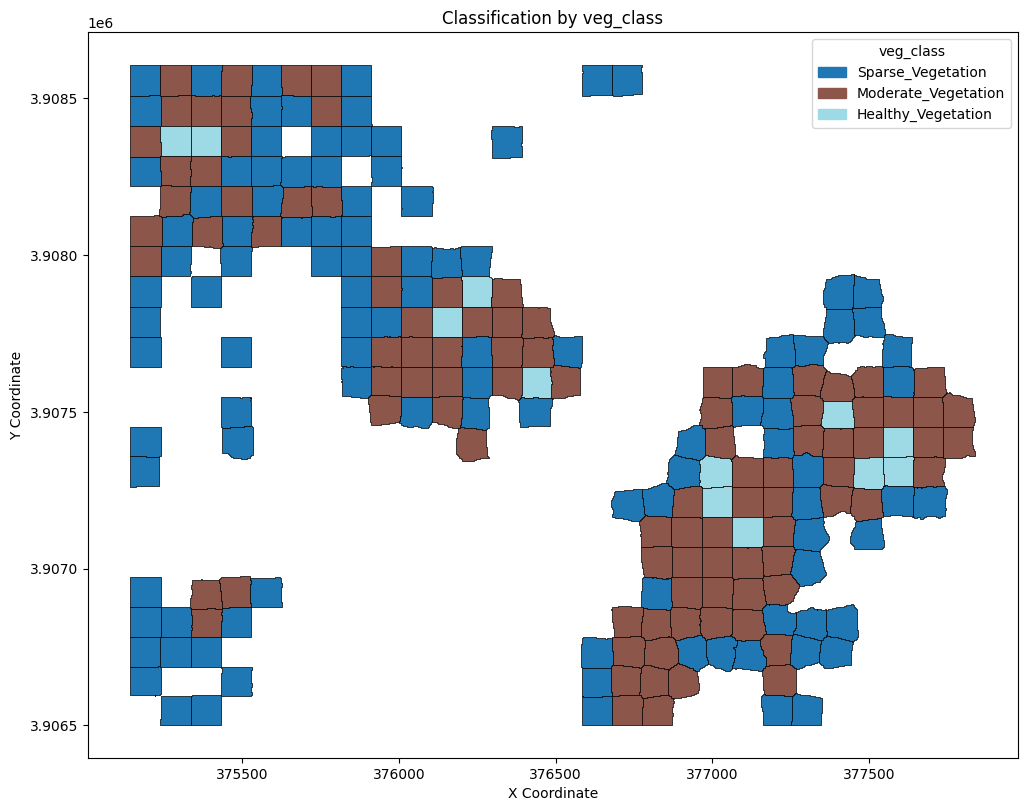

In [8]:
vegetation_rules = RuleSet(name="Vegetation_Types")
vegetation_rules.add_rule(
    name="Healthy_Vegetation",
    condition="(classification == 'Vegetation') & (NDVI > 0.6)",
)
vegetation_rules.add_rule(
    name="Moderate_Vegetation",
    condition="(classification == 'Vegetation') & (NDVI <= 0.6) & (NDVI > 0.4)",
)
vegetation_rules.add_rule(
    name="Sparse_Vegetation",
    condition="(classification == 'Vegetation') & (NDVI <= 0.4)",
)

vegetation_layer = vegetation_rules.execute(
    land_cover_layer,
    layer_manager=manager,
    layer_name="Vegetation_Types",
    result_field="veg_class",
)

fig4 = plot_classification(vegetation_layer, class_field="veg_class")
plt.show()

fig4.savefig(os.path.join(output_dir, "4_vegetation_types.png"))

## Exporting and Reviewing Results

Finally we export the land cover and vegetation layers as GeoJSON and raster, and print out the available layers from the manager.

In [9]:
land_cover_geojson = os.path.join(output_dir, "land_cover.geojson")
vegetation_geojson = os.path.join(output_dir, "vegetation_types.geojson")

layer_to_vector(land_cover_layer, land_cover_geojson)
layer_to_vector(vegetation_layer, vegetation_geojson)

land_cover_raster = os.path.join(output_dir, "land_cover.tif")
layer_to_raster(land_cover_layer, land_cover_raster, column="classification")

print(f"Land cover GeoJSON saved to {land_cover_geojson}")
print(f"Vegetation GeoJSON saved to {vegetation_geojson}")
print(f"Land cover raster saved to {land_cover_raster}")

# List all available layers from the manager
print("\nAvailable layers:")
for i, layer_name in enumerate(manager.get_layer_names(), start=1):
    print(f"  {i}. {layer_name}")

Mapping categorical values: {'Vegetation': 0, 'Other': 1}
Land cover GeoJSON saved to output/land_cover.geojson
Vegetation GeoJSON saved to output/vegetation_types.geojson
Land cover raster saved to output/land_cover.tif

Available layers:
  1. Base_Segmentation
  2. Land_Cover
  3. Vegetation_Types


## Summary

In this notebook we:
- Loaded a sample raster image.
- Performed segmentation on the raster.
- Calculated spectral indices (NDVI) and attached additional functions.
- Applied basic and hierarchical rule-based classifications to derive land cover types.
- Displayed the figures inline and exported the results for further analysis.

This example demonstrates how rule-based functions can be integrated for remote sensing and image analysis workflows using the nickyspatial library.